In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
#from custom_classes_defs.setup import *  
from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247

BATCH_SIZE = 128
# size 512 to have around 351 iterations
# size 256 to have around 707 iterations

keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

NEW_SESSION = False

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-09 22:22:47.546499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 22:22:47.546678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 22:22:47.624807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 22:22:47.768990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
# Input data path
seis_path = './data_thebe/seis/'
label_path = './data_thebe/fault/'


In [7]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train',cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',as_numpy=True, cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',as_numpy=True, cache= True)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

2024-05-09 22:23:41.045285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Loading time used 0.9031119426091512 mins


In [8]:
#print(f"training data (size = {(train_dataset.cardinality().numpy())*BATCH_SIZE})")
#print(f"validation data (size = {(val_dataset.cardinality().numpy())*BATCH_SIZE})")
#print(f"test data (size = {(test_dataset.cardinality().numpy())*BATCH_SIZE})")
#print("Data images tensor:",train_dataset.element_spec[0])
#print("Data labels tensor:",train_dataset.element_spec[1])

In [9]:


# Model configurations
conf = model_config(
    epochs= 100,
    batch_size=BATCH_SIZE,
    verbose=0,
    scaling=1,
    save_path='./output/unet',
    img_shape= (96,96),
    target_size= (96,96),
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    new_training_session=True,
    mixed_precision = False,
    multiple_gpu_device=None
)


callbacks=conf.callbacks(chkpt_monitor='val_loss', es_patience=20, lr_patience= 5, lr_factor=0.1)
conf.set( validation_data=val_dataset,  callbacks=callbacks)
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-2), 
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: False
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: None
new_training_session: True
           pos_label: 1
           save_path: ./output/unet
             scaling: 1
         target_size: (96, 96)
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 128
                       shuffle: False
                       verbose: 0


### Build model

In [10]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

#model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 3,083,969
Total trainable wieghts: 3,080,193
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-09 22:24:35.516155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-09 22:24:36.506338: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-09 22:24:46.858084: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb46c480850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 22:24:46.858140: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-09 22:24:46.951521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715286287.597683   60755 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.



Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.



Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.



Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-06.


training elapsed time: ___43.88___ minutes
...training completed!


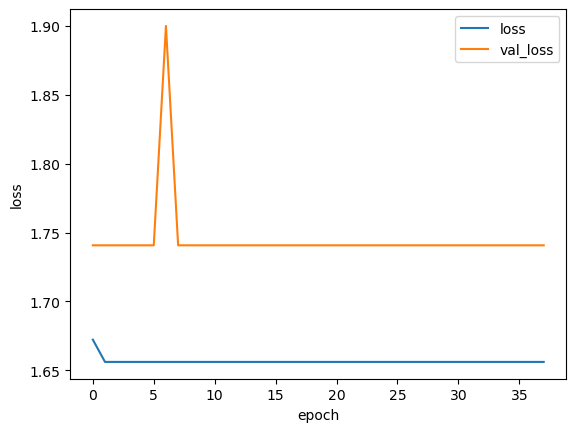

Loading time used 43.90855609178543 mins


In [11]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

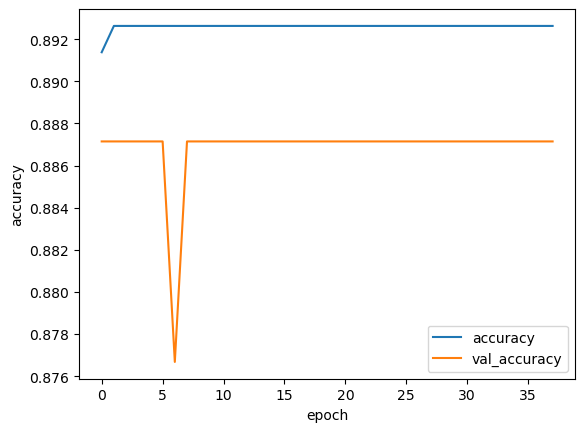

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

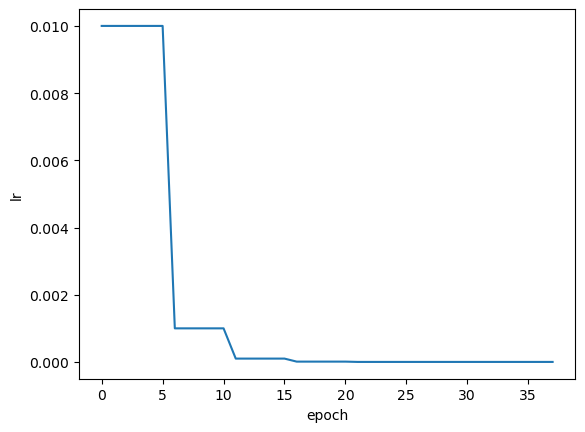

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

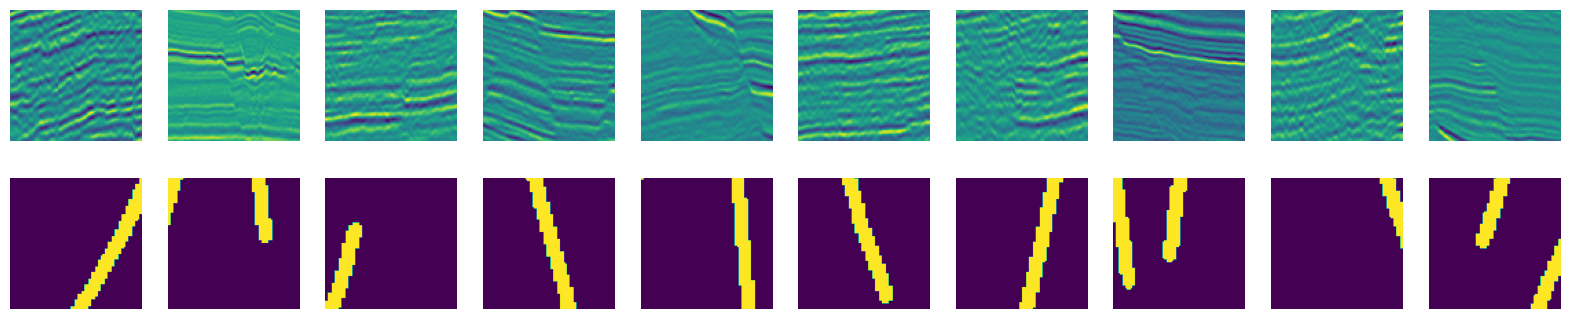

In [14]:
# check the pairs of ori images and labels

display_sample_images(val_dataset[0], val_dataset[1],(96,96))

In [15]:
time_start= time.time()
y_preds = model.predict(test_dataset[0])

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

   1/2065 [..............................] - ETA: 36:22

  11/2065 [..............................] - ETA: 10s  

  22/2065 [..............................] - ETA: 9s 

  34/2065 [..............................] - ETA: 9s

  46/2065 [..............................] - ETA: 9s

  58/2065 [..............................] - ETA: 9s

  70/2065 [>.............................] - ETA: 8s

  79/2065 [>.............................] - ETA: 9s

  90/2065 [>.............................] - ETA: 9s

 101/2065 [>.............................] - ETA: 9s

 113/2065 [>.............................] - ETA: 9s

 124/2065 [>.............................] - ETA: 8s

 135/2065 [>.............................] - ETA: 8s

 145/2065 [=>............................] - ETA: 8s

 156/2065 [=>............................] - ETA: 8s

 167/2065 [=>............................] - ETA: 8s

 179/2065 [=>............................] - ETA: 8s

 190/2065 [=>............................] - ETA: 8s

 201/2065 [=>............................] - ETA: 8s

 212/2065 [==>...........................] - ETA: 8s

 223/2065 [==>...........................] - ETA: 8s

 233/2065 [==>...........................] - ETA: 8s

 244/2065 [==>...........................] - ETA: 8s

 256/2065 [==>...........................] - ETA: 8s

 268/2065 [==>...........................] - ETA: 8s

 280/2065 [===>..........................] - ETA: 8s

 291/2065 [===>..........................] - ETA: 8s

 302/2065 [===>..........................] - ETA: 8s

 314/2065 [===>..........................] - ETA: 8s

 325/2065 [===>..........................] - ETA: 8s

 335/2065 [===>..........................] - ETA: 8s

 346/2065 [====>.........................] - ETA: 8s

 356/2065 [====>.........................] - ETA: 8s

 367/2065 [====>.........................] - ETA: 8s

 378/2065 [====>.........................] - ETA: 7s

 389/2065 [====>.........................] - ETA: 7s

 400/2065 [====>.........................] - ETA: 7s

 410/2065 [====>.........................] - ETA: 7s

 420/2065 [=====>........................] - ETA: 7s

 431/2065 [=====>........................] - ETA: 7s

 442/2065 [=====>........................] - ETA: 7s

 453/2065 [=====>........................] - ETA: 7s

 464/2065 [=====>........................] - ETA: 7s

 475/2065 [=====>........................] - ETA: 7s

 486/2065 [======>.......................] - ETA: 7s

 496/2065 [======>.......................] - ETA: 7s

 507/2065 [======>.......................] - ETA: 7s

 518/2065 [======>.......................] - ETA: 7s

 529/2065 [======>.......................] - ETA: 7s

 540/2065 [======>.......................] - ETA: 7s

 551/2065 [=======>......................] - ETA: 7s

 562/2065 [=======>......................] - ETA: 7s

 573/2065 [=======>......................] - ETA: 7s

 584/2065 [=======>......................] - ETA: 7s

 595/2065 [=======>......................] - ETA: 6s

 606/2065 [=======>......................] - ETA: 6s

 617/2065 [=======>......................] - ETA: 6s

 628/2065 [========>.....................] - ETA: 6s

 638/2065 [========>.....................] - ETA: 6s

 649/2065 [========>.....................] - ETA: 6s

 660/2065 [========>.....................] - ETA: 6s

 671/2065 [========>.....................] - ETA: 6s

 683/2065 [========>.....................] - ETA: 6s

 694/2065 [=========>....................] - ETA: 6s

 705/2065 [=========>....................] - ETA: 6s

 716/2065 [=========>....................] - ETA: 6s

 727/2065 [=========>....................] - ETA: 6s

 738/2065 [=========>....................] - ETA: 6s

 750/2065 [=========>....................] - ETA: 6s

 761/2065 [==========>...................] - ETA: 6s

 772/2065 [==========>...................] - ETA: 6s

 783/2065 [==========>...................] - ETA: 6s

 795/2065 [==========>...................] - ETA: 6s

 805/2065 [==========>...................] - ETA: 5s

 816/2065 [==========>...................] - ETA: 5s

 827/2065 [===========>..................] - ETA: 5s

 838/2065 [===========>..................] - ETA: 5s

 849/2065 [===========>..................] - ETA: 5s

 860/2065 [===========>..................] - ETA: 5s

 871/2065 [===========>..................] - ETA: 5s

 881/2065 [===========>..................] - ETA: 5s

 891/2065 [===========>..................] - ETA: 5s

 901/2065 [============>.................] - ETA: 5s

 912/2065 [============>.................] - ETA: 5s

 923/2065 [============>.................] - ETA: 5s

 933/2065 [============>.................] - ETA: 5s

 945/2065 [============>.................] - ETA: 5s

 956/2065 [============>.................] - ETA: 5s

 967/2065 [=============>................] - ETA: 5s

 978/2065 [=============>................] - ETA: 5s

 989/2065 [=============>................] - ETA: 5s

1000/2065 [=============>................] - ETA: 5s

1012/2065 [=============>................] - ETA: 5s

1023/2065 [=============>................] - ETA: 4s

1035/2065 [==============>...............] - ETA: 4s

1046/2065 [==============>...............] - ETA: 4s

1057/2065 [==============>...............] - ETA: 4s

1068/2065 [==============>...............] - ETA: 4s

1079/2065 [==============>...............] - ETA: 4s

1091/2065 [==============>...............] - ETA: 4s

1103/2065 [===============>..............] - ETA: 4s

1115/2065 [===============>..............] - ETA: 4s

1127/2065 [===============>..............] - ETA: 4s

1139/2065 [===============>..............] - ETA: 4s

1150/2065 [===============>..............] - ETA: 4s

1162/2065 [===============>..............] - ETA: 4s

1173/2065 [================>.............] - ETA: 4s

1185/2065 [================>.............] - ETA: 4s

1197/2065 [================>.............] - ETA: 4s

1207/2065 [================>.............] - ETA: 4s

1217/2065 [================>.............] - ETA: 4s

1228/2065 [================>.............] - ETA: 3s

1239/2065 [=================>............] - ETA: 3s

1250/2065 [=================>............] - ETA: 3s

1261/2065 [=================>............] - ETA: 3s

1272/2065 [=================>............] - ETA: 3s

1283/2065 [=================>............] - ETA: 3s

1293/2065 [=================>............] - ETA: 3s

1304/2065 [=================>............] - ETA: 3s

1316/2065 [==================>...........] - ETA: 3s

1327/2065 [==================>...........] - ETA: 3s

1339/2065 [==================>...........] - ETA: 3s

1350/2065 [==================>...........] - ETA: 3s

1361/2065 [==================>...........] - ETA: 3s

1372/2065 [==================>...........] - ETA: 3s

1384/2065 [===================>..........] - ETA: 3s

1396/2065 [===================>..........] - ETA: 3s

1407/2065 [===================>..........] - ETA: 3s

1418/2065 [===================>..........] - ETA: 3s

1429/2065 [===================>..........] - ETA: 3s

1441/2065 [===================>..........] - ETA: 2s

1452/2065 [====================>.........] - ETA: 2s

1462/2065 [====================>.........] - ETA: 2s

1472/2065 [====================>.........] - ETA: 2s

1483/2065 [====================>.........] - ETA: 2s

1494/2065 [====================>.........] - ETA: 2s

1505/2065 [====================>.........] - ETA: 2s

1515/2065 [=====================>........] - ETA: 2s

1526/2065 [=====================>........] - ETA: 2s

1537/2065 [=====================>........] - ETA: 2s

1548/2065 [=====================>........] - ETA: 2s

1559/2065 [=====================>........] - ETA: 2s

1570/2065 [=====================>........] - ETA: 2s

1580/2065 [=====================>........] - ETA: 2s

1591/2065 [======================>.......] - ETA: 2s

1602/2065 [======================>.......] - ETA: 2s

1613/2065 [======================>.......] - ETA: 2s

1624/2065 [======================>.......] - ETA: 2s

1635/2065 [======================>.......] - ETA: 2s

1646/2065 [======================>.......] - ETA: 1s

1657/2065 [=======================>......] - ETA: 1s

1667/2065 [=======================>......] - ETA: 1s

1678/2065 [=======================>......] - ETA: 1s

1689/2065 [=======================>......] - ETA: 1s

1700/2065 [=======================>......] - ETA: 1s

1712/2065 [=======================>......] - ETA: 1s

1724/2065 [========================>.....] - ETA: 1s

1736/2065 [========================>.....] - ETA: 1s

1747/2065 [========================>.....] - ETA: 1s

1758/2065 [========================>.....] - ETA: 1s

1769/2065 [========================>.....] - ETA: 1s

1781/2065 [========================>.....] - ETA: 1s

1793/2065 [=========================>....] - ETA: 1s

1805/2065 [=========================>....] - ETA: 1s

1816/2065 [=========================>....] - ETA: 1s

1828/2065 [=========================>....] - ETA: 1s

1839/2065 [=========================>....] - ETA: 1s

1850/2065 [=========================>....] - ETA: 1s

1861/2065 [==========================>...] - ETA: 0s

1873/2065 [==========================>...] - ETA: 0s

1885/2065 [==========================>...] - ETA: 0s

1896/2065 [==========================>...] - ETA: 0s

1906/2065 [==========================>...] - ETA: 0s

1917/2065 [==========================>...] - ETA: 0s

1928/2065 [===========================>..] - ETA: 0s

1940/2065 [===========================>..] - ETA: 0s

1952/2065 [===========================>..] - ETA: 0s

1963/2065 [===========================>..] - ETA: 0s

1975/2065 [===========================>..] - ETA: 0s

1987/2065 [===========================>..] - ETA: 0s

1999/2065 [============================>.] - ETA: 0s

2010/2065 [============================>.] - ETA: 0s

2021/2065 [============================>.] - ETA: 0s

2032/2065 [============================>.] - ETA: 0s

2043/2065 [============================>.] - ETA: 0s

2055/2065 [============================>.] - ETA: 0s

2065/2065 [==============================] - ETA: 0s

2065/2065 [==============================] - 11s 5ms/step


Loading time used 0.25936222871144615 mins


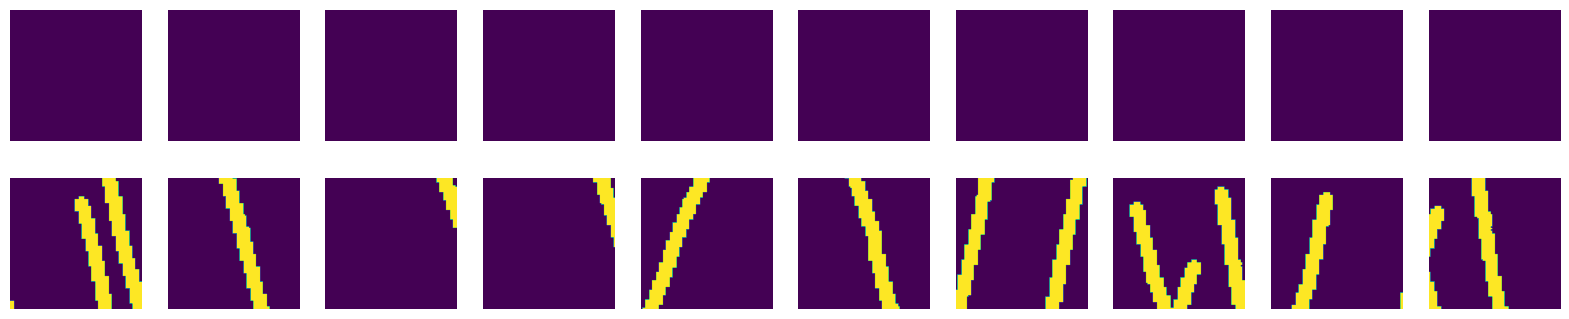

In [16]:
display_sample_images(y_preds, test_dataset[1],(96,96))

In [17]:
#time_start= time.time()

#print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

#model.evaluate(x=test_dataset)
#time_end = (time.time()-time_start)/60
#print(f'Loading time used {time_end} mins')

In [18]:
# Using scikit-learn
#scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
#print(scores)


In [19]:
#if NEW_SESSION:
#    thebe_data.display_sample_image(y_preds, 'test')